In [22]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score


In [25]:
df = pd.read_csv("/content/synthetic_transactions.csv")

In [26]:
# Drop non-numeric columns
df_processed = df.drop(columns=["transaction_id", "sender_address", "receiver_address"])

In [27]:
df_processed.head()

,amount,timestamp,gas_fee,transaction_count,wallet_age,is_fraud
0,1.0374,1740657035,0.033979,3,269,0
1,21.9717,1721771081,0.078390,225,96,0
2,48.6431,1732206524,0.067293,138,201,0
3,68.9254,1736983993,0.016187,375,44,0
4,96.2830,1725899748,0.025305,91,306,1


In [29]:
# Convert timestamp to datetime and extract features
df_processed["timestamp"] = pd.to_datetime(df_processed["timestamp"], unit="s")
df_processed["hour"] = df_processed["timestamp"].dt.hour
df_processed["day_of_week"] = df_processed["timestamp"].dt.dayofweek

In [30]:
# Drop original timestamp column
df_processed = df_processed.drop(columns=["timestamp"])

In [31]:
df_processed.head()

,amount,gas_fee,transaction_count,wallet_age,is_fraud,hour,day_of_week
0,1.0374,0.033979,3,269,0,11,3
1,21.9717,0.078390,225,96,0,21,1
2,48.6431,0.067293,138,201,0,16,3
3,68.9254,0.016187,375,44,0,23,2
4,96.2830,0.025305,91,306,1,16,0


In [32]:
# Separate features and target
X = df_processed.drop(columns=["is_fraud"])
y = df_processed["is_fraud"]

In [33]:

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.3,stratify=y)

print(X_train.shape)
print(X_test.shape)

(3500, 6)
(1500, 6)


In [34]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

columns = ['amount', 'gas_fee', 'transaction_count', 'wallet_age', 'hour', 'day_of_week']

scaler = MinMaxScaler()
for c in columns:
  X_train[c] = X_train[c].apply(lambda x: np.log(x) if x > 0 else 0)
  X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
np.isnan(X_train).sum()


0

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

tuned_parameters = [
    { "gamma": [1, 0.1, 0.01, 0.001], "C": [1, 10, 100, 1000] },
]

grid = GridSearchCV(SVC(kernel='linear'), tuned_parameters, refit=True, verbose=2, cv=5, scoring='f1')

grid.fit(X_train, y_train)
best_params = grid.best_params_
print("Best Parameters:", best_params)

best_model = grid.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................................C=1, gamma=1; total time=   0.2s
[CV] END .......................................C=1, gamma=1; total time=   0.2s
[CV] END .......................................C=1, gamma=1; total time=   0.2s
[CV] END .......................................C=1, gamma=1; total time=   0.2s
[CV] END .......................................C=1, gamma=1; total time=   0.2s
[CV] END .....................................C=1, gamma=0.1; total time=   0.2s
[CV] END .....................................C=1, gamma=0.1; total time=   0.2s
[CV] END .....................................C=1, gamma=0.1; total time=   0.2s
[CV] END .....................................C=1, gamma=0.1; total time=   0.2s
[CV] END .....................................C=1, gamma=0.1; total time=   0.2s
[CV] END ....................................C=1, gamma=0.01; total time=   0.4s
[CV] END ....................................C=1

In [36]:
grid.best_params_

{'C': 100, 'gamma': 1}

In [37]:
grid.best_score_

0.6559416628320627

In [38]:
from sklearn.metrics import accuracy_score
predicted_y_acc = grid.predict(X_test)
predicted_y_acc = (predicted_y_acc > 0.5).astype('int32')
accuracy_score(predicted_y_acc, y_test)

0.738

In [39]:
print("Tuned Hyperparameters :", grid.best_params_)
print("Train F1 Score :",grid.best_score_)
best_y_pr = grid.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Tuned Hyperparameters : {'C': 100, 'gamma': 1}
Train F1 Score : 0.6559416628320627
Test F1 Score:  0.6260704091341579


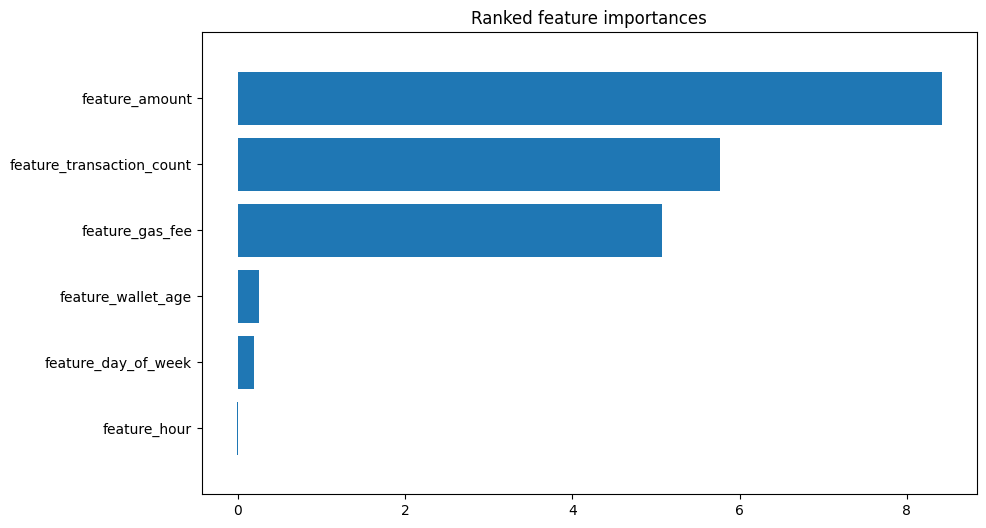

In [40]:
from matplotlib import pyplot as plt
feat_importances = grid.best_estimator_.coef_[0]
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();